# CONTENT SUMMARY:
## import 3 SD datasets 



## get SSH satellite data for the area and time 
### get front locations with SSH threshold 



In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import SD_Project as SD
import xarray as xr
import numpy as np
import gsw
import datetime
import seawater as sw
import cartopy
import cartopy.crs as ccrs
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import colorbar, colors
import matplotlib
import matplotlib.path as mpath
#import seaborn as sns
#sns.set_context("talk")

filepath0= 'C:/Users/Hanna/Python/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1564884498845.nc' #minutly resolution
DS20= SD.load_data(filepath0)

filepath2= 'D:/Studium_der_Physik/M.Sc/Oceanography_Master/Masterthesis/SD_data/1022_new_merged.nc'
DS22= xr.open_dataset(filepath2)

filepath3 = 'D:/Studium_der_Physik/M.Sc/Oceanography_Master/Masterthesis/SD_data/1023_new_merged.nc'
DS23 = xr.open_dataset(filepath3)
c="#5077d2"

### download data from ERA5: 

In [24]:
### Download ERA5 Qnet data to estimate an error based on temporal variability for the SD Qturb #########
import certifi
import cdsapi
import urllib3

http = urllib3.PoolManager(
    cert_reqs='CERT_REQUIRED',
    ca_certs=certifi.where()
)

c = cdsapi.Client(timeout=75,url= 'https://cds.climate.copernicus.eu/api/v2',
key= '24891:44aabe89-39a3-4335-8bb4-be18ae02be29',verify=1)

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'surface_latent_heat_flux', 'surface_sensible_heat_flux',
        ],
        'year': '2019',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            -33, -180, -62,
            180,
        ],
    },
    'ERA5_scale_error_estimate_2019_Jan_Aug.nc')

2021-06-29 10:55:04,070 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2021-06-29 10:55:04,455 INFO Request is queued
2021-06-29 10:55:09,415 INFO Request is running
2021-06-29 11:17:25,563 INFO Request is completed
2021-06-29 11:17:25,565 INFO Downloading https://download-0003.copernicus-climate.eu/cache-compute-0003/cache/data7/adaptor.mars.internal-1624958015.4364157-5007-18-ed6bb88a-8338-4fc5-b7d4-9e20afbf13a5.nc to ERA5_scale_error_estimate_2019_Jan_Aug.nc (3.7G)
2021-06-29 11:31:28,754 INFO Download rate 4.4M/s      


Result(content_length=3930332448,content_type=application/x-netcdf,location=https://download-0003.copernicus-climate.eu/cache-compute-0003/cache/data7/adaptor.mars.internal-1624958015.4364157-5007-18-ed6bb88a-8338-4fc5-b7d4-9e20afbf13a5.nc)

## read this data : 

In [2]:
file8='D:/Studium_der_Physik/PhD_oceanography/paper_SD_smallfronts/data/ERA5_scale_error_estimate_2019_Jan_Aug.nc'
DS_Qturb_E5= xr.open_dataset(file8)

In [3]:
# co-locationcode from before: 
lon1=SData.longitude[:]
lat1=SData.latitude[:]

lat2= ERA5.latitude[:]
lon2=ERA5.longitude[:]
#time_corr= ERA5.time[436:5140]
import mpu 


#dist= np.zeros((len(lat1),len(lat2),len(lon2)))
lat_path= np.zeros(len(lat1))
lon_path= np.zeros(len(lat1))
lat_indx = np.zeros(len(lat1),dtype=int)
lon_indx= np.zeros(len(lat1),dtype=int)
for i in range(0,len(lat1)):
    if np.isnan(lat1[i]):
        lat_path[i]=np.nan
    else:
        lat_indx[i]= np.argmin(np.abs(lat2-lat1[i]))
        lat_path[i]= lat2[lat_indx[i]]
    if np.isnan(lon1[i]):
        lon_path[i]=np.nan
    else:
        lon_indx[i]= np.argmin(np.abs(lon2-lon1[i]))
        lon_path[i]= lon2[lon_indx[i]]

NameError: name 'SData' is not defined

In [4]:
#### for SD1020 things are more complicated and I don't know why ! something with the formate, but solved like this:
idx=np.where(DS20.time.dt.minute == 0)[0] # select index on top of every hour

DS20_lat_1hr= DS20.latitude[idx]
DS20_lon_1hr=DS20.longitude[idx]
DS20_time_1hr= DS20.time[idx]

### easy for SD1022 and 1023
sd22_1hr=DS22.sel(time= DS22.time.dt.minute == 0)
sd23_1hr=DS23.sel(time= DS23.time.dt.minute == 0)

In [5]:
### cut Era5 data set , so time matches the SD deployment for each platform:( to only keep time of deployment of SDs from ERA5 data set)

inx_start= int(np.where(DS_Qturb_E5.time==DS20_time_1hr[0])[0])
inx_stop= int(np.where(DS_Qturb_E5.time==DS20_time_1hr[-1])[0])
E5_20= DS_Qturb_E5.isel(time=slice(inx_start,inx_stop))


inx_start= int(np.where(DS_Qturb_E5.time==sd22_1hr.time[0])[0]) ### stop for Sd1022 not in era5 dataset
#inx_stop= int(np.where(DS_Qturb_E5.time==sd22_1hr.time[-1])[0])
E5_22= DS_Qturb_E5.isel(time=slice(inx_start,len(DS_Qturb_E5.time)))

inx_start= int(np.where(DS_Qturb_E5.time==sd23_1hr.time[0])[0])
inx_stop= int(np.where(DS_Qturb_E5.time==sd23_1hr.time[-1])[0])
E5_23= DS_Qturb_E5.isel(time=slice(inx_start,inx_stop))


In [6]:
def x_round(x):
    return round(x*4)/4
##### to select the long and lat at Sd position we round to nearest grid point for ERA5###
round_DS20_lat=[]
round_DS20_lon=[]

#round_DS20_lon=np.zeros(len(DS20.longitude))
for i in np.arange(len(DS20.latitude)):
    round_DS20_lat.append(x_round(DS20.latitude.values[i]))
    round_DS20_lon.append(x_round(DS20.longitude.values[i]))
#round_DS20_lon= x_round(DS20.longitude)


ValueError: cannot convert float NaN to integer

In [7]:
round_DS22_lat=[]
round_DS22_lon=[]

for i in np.arange(len(DS22.latitude)):
    round_DS22_lat.append(x_round(DS22.latitude.values[i]))
    round_DS22_lon.append(x_round(DS22.longitude.values[i]))
    
round_DS23_lat=[]
round_DS23_lon=[]

for i in np.arange(len(DS23.latitude)):
    round_DS23_lat.append(x_round(DS23.latitude.values[i]))
    round_DS23_lon.append(x_round(DS23.longitude.values[i]))

ValueError: cannot convert float NaN to integer

In [9]:
import pandas as pd
df = pd.DataFrame({'A':[1,1,3,2,6,2,8]})
a = df['A'].unique()
print(sorted(a))

[1, 2, 3, 6, 8]


In [ ]:
#indd=np.where(np.isfinite(round_DS20_lat))[0]
round_DS20_lat=np.array(round_DS20_lat)
round_DS20_lat= round_DS20_lat[~np.isnan(round_DS20_lat)]

round_DS20_lon=np.array(round_DS20_lon)
round_DS20_lon= round_DS20_lon[~np.isnan(round_DS20_lon)]
len(round_DS20_lon)== len(round_DS20_lat) #### only contunie if this is true ! 

In [8]:
## for sd1022:
round_DS22_lat=np.array(round_DS22_lat)
round_DS22_lat= round_DS22_lat[~np.isnan(round_DS22_lat)]

round_DS22_lon=np.array(round_DS22_lon)
round_DS22_lon= round_DS22_lon[~np.isnan(round_DS22_lon)]
len(round_DS22_lon)== len(round_DS22_lat) #### only contunie if this is true ! 

NameError: name 'round_DS22_lat' is not defined

In [19]:
## for sd1023:
round_DS23_lat=np.array(round_DS23_lat)
round_DS23_lat= round_DS23_lat[~np.isnan(round_DS23_lat)]

round_DS23_lon=np.array(round_DS23_lon)
round_DS23_lon= round_DS23_lon[~np.isnan(round_DS23_lon)]
len(round_DS23_lon)== len(round_DS23_lat) #### only contunie if this is true ! 

NameError: name 'round_DS23_lat' is not defined

In [107]:
### keep only unique locations: NOR sure if this is right  to do ?!?


In [20]:
## example to explain sets and pairs 
k1= [4, 4, 5, 7]
k2= [0.5, 0.5, 3, 2]
coords=[(k1[i],k2[i]) for i in range(4)]
m= sorted(set(coords)) ### sorted converts set into list in the defined order !!!!!!!!!!!!! YEAYYYY


In [21]:
## get unique positions for SD depolyment: 
c=[(round_DS20_lat[i],round_DS20_lon[i] )for i in range(len(round_DS20_lon)-1)]
m20= sorted(set(c))

coords=[(round_DS22_lat[i],round_DS22_lon[i] )for i in range(len(round_DS22_lon))]
m22= sorted(set(coords))

coords=[(round_DS23_lat[i],round_DS23_lon[i] )for i in range(len(round_DS23_lon))]
m23= sorted(set(coords))

NameError: name 'round_DS23_lon' is not defined

In [22]:
no_positions=100# number of position we observe
l= 240 ## hours of observation
Qturb20=[]
for j in range(no_positions):
    Qturb20.append((DS_Qturb_E5.sel(latitude=m20[j][0],longitude= m20[j][1]).slhf/3600+DS_Qturb_E5.sel(latitude=m20[j][0],longitude= m20[j][1]).sshf/3600)[:l])

Qvar_mean20=[] ## avergae over all 
for j in range(l):
    for i in range(no_positions):
        Qvar_mean_ind=[]
        Qvar_mean_ind.append(Qturb[i][0]-Qturb[i][j])
    Qvar_mean20.append(np.mean(Qvar_mean_ind))

Qturb22=[]
for j in range(no_positions):
    Qturb22.append((DS_Qturb_E5.sel(latitude=m22[j][0],longitude= m22[j][1]).slhf/3600+DS_Qturb_E5.sel(latitude=m22[j][0],longitude= m22[j][1]).sshf/3600)[:l])

Qvar_mean22=[] ## avergae over all 
for j in range(l):
    for i in range(no_positions):
        Qvar_mean_ind=[]
        Qvar_mean_ind.append(Qturb[i][0]-Qturb[i][j])
    Qvar_mean22.append(np.mean(Qvar_mean_ind))
    
Qturb23=[]
for j in range(no_positions):
    Qturb23.append((DS_Qturb_E5.sel(latitude=m23[j][0],longitude= m23[j][1]).slhf/3600+DS_Qturb_E5.sel(latitude=m23[j][0],longitude= m23[j][1]).sshf/3600)[:l])

Qvar_mean23=[] ## avergae over all 
for j in range(l):
    for i in range(no_positions):
        Qvar_mean_ind=[]
        Qvar_mean_ind.append(Qturb[i][0]-Qturb[i][j])
    Qvar_mean23.append(np.mean(Qvar_mean_ind))

KeyError: 180.0

In [ ]:
len(m20)

In [23]:
no_positions=300# number of position we observe
l= 240 ## hours of observation
Qturb20=[]
for j in range(no_positions):
    Qturb20.append((DS_Qturb_E5.sel(latitude=m20[j][0],longitude= m20[j][1]).slhf/3600+DS_Qturb_E5.sel(latitude=m20[j][0],longitude= m20[j][1]).sshf/3600)[:l])

Qvar_mean20p500=[] ## avergae over all 
for j in range(l):
    for i in range(no_positions):
        Qvar_mean_ind=[]
        Qvar_mean_ind.append(Qturb20[i][0]-Qturb20[i][j])
    Qvar_mean20p500.append(np.mean(Qvar_mean_ind))

KeyError: 180.0

In [200]:
no_positions=1000# number of position we observe
l= 240 ## hours of observation
Qturb20=[]
for j in range(no_positions):
    Qturb20.append((DS_Qturb_E5.sel(latitude=m20[j][0],longitude= m20[j][1]).slhf/3600+DS_Qturb_E5.sel(latitude=m20[j][0],longitude= m20[j][1]).sshf/3600)[:l])

Qvar_mean20p1000=[] ## avergae over all 
for j in range(l):
    for i in range(no_positions):
        Qvar_mean_ind=[]
        Qvar_mean_ind.append(Qturb20[i][0]-Qturb20[i][j])
    Qvar_mean20p1000.append(np.mean(Qvar_mean_ind))

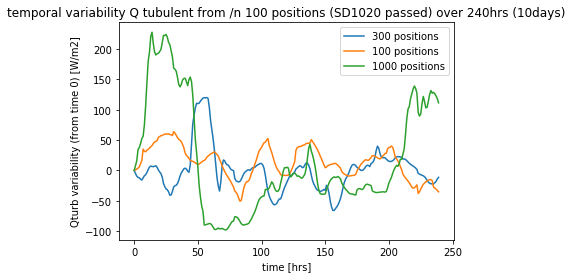

In [206]:
fig, (ax1) = plt.subplots(1,1)

ax1.plot(Qvar_mean20p500, label='300 positions')
ax1.plot(Qvar_mean20, label='100 positions')
ax1.plot(Qvar_mean20p1000, label= '1000 positions')

ax1.set_title('temporal variability Q tubulent from /n 100 positions (SD1020 passed) over 240hrs (10days)')
ax1.set_ylabel('Qturb variability (from time 0) [W/m2]')
ax1.set_xlabel('time [hrs]')
ax1.legend()

#plt.savefig("errorscale_era5_Sd1020diffrentpositions_040821.png", bbox_inches='tight', transparent=True)

In [13]:
no_positions=100#len(DS23.latitude)
l= 30
Q_mean=[]
Qsens_change=[]
Qstd=[]
for j in range(no_positions):
    Qstats=[]
    Qsens= (DS_Qturb_E5.sel(latitude=round_DS20_lat[j],longitude= round_DS20_lon[j]).slhf/3600+DS_Qturb_E5.sel(latitude=round_DS20_lat[j],longitude= round_DS20_lon[j]).sshf/3600)[:l]
    for i in range(l):
        Qsens_change.append(np.abs(Qsens[0]-Qsens[i]))
        Qstats.append(np.array(Qsens_change))
    Q_mean.append(np.nanmean([x[j] for x in Qstats]))
    Qstd.append(np.nanstd([x[j] for x in Qstats]))
            

            

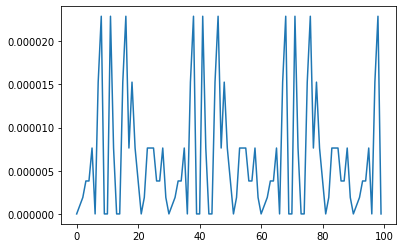

In [14]:
#### change approach and just look at unique lat/long###
# look at how value of Qturb changes 
plt.plot(Qstd)

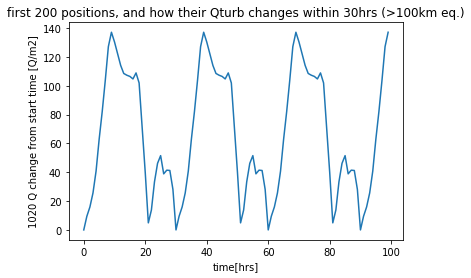

In [15]:
plt.title('first 200 positions, and how their Qturb changes within 30hrs (>100km eq.)')
plt.plot(Q_mean)
plt.ylabel('1020 Q change from start time [Q/m2]')
plt.xlabel('time[hrs]')
#plt.plot([Q_mean[i]+Qstd[i] for i in range(len(Q_mean))])
plt.savefig("errorscale_era5_20721.png", bbox_inches='tight', transparent=True)

In [24]:
Qsens_20_pt1= (DS_Qturb_E5.sel(latitude=round_DS20_lat[1],longitude= round_DS20_lon[1]).slhf/3600)[:150]
Qsens_20_pt5= (DS_Qturb_E5.sel(latitude=round_DS20_lat[5],longitude= round_DS20_lon[5]).slhf/3600)
Qsens_20_pt10= (DS_Qturb_E5.sel(latitude=round_DS20_lat[10],longitude= round_DS20_lon[10]).slhf/3600)
Qsens_20_pt100= (DS_Qturb_E5.sel(latitude=round_DS20_lat[100],longitude= round_DS20_lon[100]).slhf/3600)

time_change_1= np.arange(len(Qsens_20_pt1))

Qsens_change1=[]
Qsens_change5=[]
for i in range(len(Qsens_20_pt1)):
    Qsens_change1.append(np.abs(Qsens_20_pt1[0]-Qsens_20_pt1[i]))
    Qsens_change5.append(np.abs(Qsens_20_pt5[0]-Qsens_20_pt5[i]))
plt.plot(Qsens_change10)

plt.plot(Qsens_20_pt100)

NameError: name 'Qsens_change10' is not defined

In [25]:
### then selcet ERA5 from paths####
DS_Qturb_E5_20=[]
for i in len(round_DS20_lat):
    DS_Qturb_E5_20.append(DS_Qturb_E5.sel(latitude=round_DS20_lat[i]))

TypeError: 'int' object is not iterable

In [164]:
# co-locatetion: I want to find the box that is closest to the SD at any given point. 
# do this for each Data set:
# 1. hourly snapshot for SD data (where was it on top of every hour) DONE
# 2
#DS20= DS20.se
#sd22_1hr=DS22.sel(time='00')
#DS_Qturb_E5.sel(time=DS20.time[0])

#sd20_1hr=DS20.sel(time= DS20.time.dt.minute == 0) # only take values on top of every hour, ERA5 is also hourly snapshot

#ds.latitude


In [ ]:
# contunuation of the original file: 

In [26]:
fronts_long=np.genfromtxt("long.txt", unpack=True)
fronts_lat_apf= np.genfromtxt("lat_apf.txt", unpack=True)

fronts_lat_saf= np.genfromtxt("lat_saf.txt", unpack=True)
fronts_lat_saccf= np.genfromtxt("lat_saccf.txt", unpack=True)
fronts_latt_sby= np.genfromtxt("lat_sby.txt", unpack=True)

In [27]:
filepath4 = 'D:/Studium_der_Physik/M.Sc/Oceanography_Master/Masterthesis/Data/MADT_10419_310819_aviso.nc'
MADT = xr.open_dataset(filepath4)

In [28]:
MADT.adt

<xarray.DataArray 'adt' (time: 153, latitude: 240, longitude: 1440)>
[52876800 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... -30.62 -30.38 -30.12
  * time       (time) datetime64[ns] 2019-04-01 2019-04-02 ... 2019-08-31
Attributes:
    comment:        The absolute dynamic topography is the sea surface height...
    grid_mapping:   crs
    long_name:      Absolute dynamic topography
    standard_name:  sea_surface_height_above_geoid
    units:          m
    _ChunkSizes:    [ 1 50 50]
    history:        From http://ddo-aviso.vlandata.cls.fr:41080/thredds/dodsC...

In [14]:
filepath5 = 'D:/Studium_der_Physik/M.Sc/Oceanography_Master/Masterthesis/Data/SSanomaly_1april19_31august2019_aviso.nc'
SSA= xr.open_dataset(filepath5)

In [15]:
april_adt= MADT.adt[0]

NameError: name 'MADT' is not defined

In [8]:
filepath11= 'C:/Users/Hanna/Python/downloadSSH_data_map/out_cut_mean.nc'
Map_cont= xr.open_dataset(filepath11)


In [9]:
for i in range(50):
    if np.any(np.isfinite(Map_cont.adt[:,i,:])):
        break
i

5

In [37]:
np.savetxt('Longitudes.txt', Map_cont.longitude)   

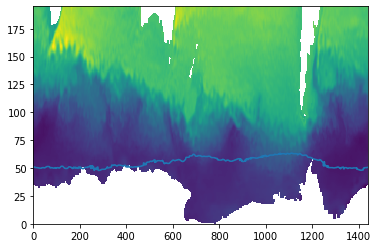

In [10]:
plt.pcolor(SSH_mean_SH[0])

plt.plot(-np.array(pf))

In [16]:
MADT_lat

NameError: name 'MADT_lat' is not defined

In [10]:
MADT_lat= Map_cont.latitude   # 
SSH_mean_SH= Map_cont.adt[:,5:,:]# adt_mean#april_adt#k
#sby1=[]
#Saccf=[]
#apf=[]
saf=[]
#stf=[]
pf=[]
saccf=[]
for i in range(0,1440):
    #sby1.append(MADT_lat[np.nanargmin(np.abs(SSH_mean_SH[:,i]--0.0700))])
    saccf.append(MADT_lat[np.nanargmin(np.abs(SSH_mean_SH[:,:,i]-(-0.943)))])
    #apf.append(MADT_lat[np.nanargmin(np.abs(SSH_mean_SH[:,i]-0.4035))])
    saf.append(MADT_lat[np.nanargmin(np.abs(SSH_mean_SH[:,:,i]-0.03))])
    pf.append(MADT_lat[np.nanargmin(np.abs(SSH_mean_SH[:,:,i]-(-0.48)))])

In [9]:
np.savetxt('pf_April_August2029_latitudes.txt', pf)
np.savetxt('saf_April_August2029_latitudes.txt', saf)
np.savetxt('saccf_April_August2029_latitudes.txt', saccf)

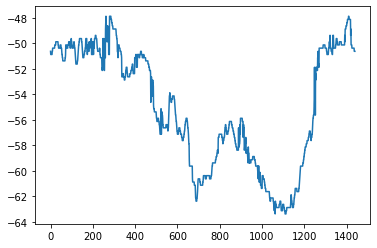

In [39]:
plt.plot(pf)

In [12]:
MADT_lon= MADT.longitude
np.savetxt('bigfronts_MADT_lon.txt', MADT_lon)
np.savetxt('bisgfronts_Saccf_lat.txt', Saccf)
np.savetxt('bisgfronts_apf_lat.txt', apf)

NameError: name 'MADT' is not defined

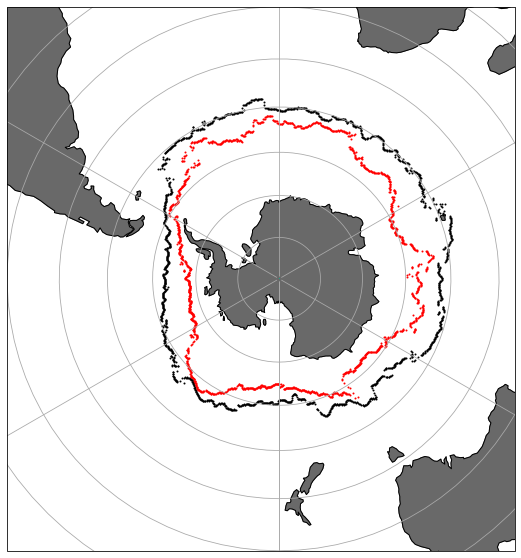

In [11]:
x= Map_cont.longitude
#y1= sby2
#y2= Saccf# Southern ACC front 
#y3= apf#antarctiv polar front 
#y4= saf
#y5= stf

fig = plt.figure(figsize=[10,10])
ax = plt.axes(projection=ccrs.SouthPolarStereo())
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None, color='darkgrey')
gl.n_steps = 90
ax.add_feature(cartopy.feature.LAND, color='dimgrey')
ax.coastlines()
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_extent([-180, 60, -90, -30], ccrs.PlateCarree())

#ax.scatter(x, y1, transform=ccrs.PlateCarree(), s= 5, color='k')
#ax.plot(MADT_lon, saccf, transform=ccrs.PlateCarree(), s= 1, color= 'r')# Southern ACC front 
ax.scatter(x, pf, transform=ccrs.PlateCarree(), s= 1, color = 'k')#antarctiv polar front 
ax.scatter(x, saccf, transform=ccrs.PlateCarree(), s= 1, color = 'r')
ax.pcolor(SSH_mean_SH[0])
#ax.scatter(x, y4, transform=ccrs.PlateCarree(), s= 5)
#ax.scatter(x, y5, transform=ccrs.PlateCarree(), s= 5)
#plt.savefig("New_fronts_whodis.png", bbox_inches='tight', transparent=True)


# THIS MAP FOR THE PAPER

In [44]:
#DS20.time[29510:95630]

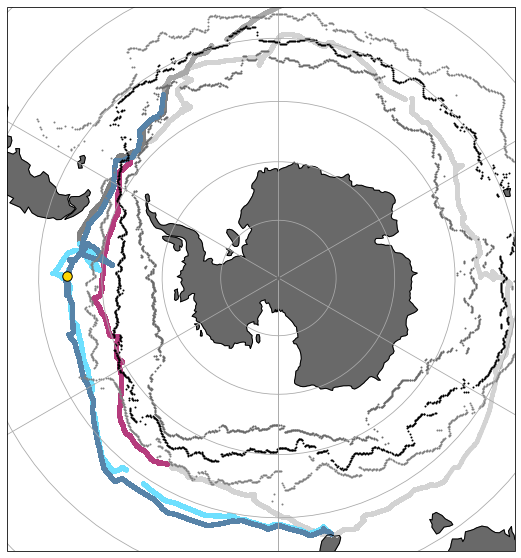

In [17]:
# this map is used for the paper
col=['#b53c7d',
"#6ee0ff",
"#5783a8"]
mooring_col='gold'#'#b1c8eb'#'green'
#['Crimson', "#76565f", 'OrangeRed','DarkOrange'] #["#ec4b18", "#76565f", "#f7306e", "#ae2a51"]
gr= ['lightgrey','grey', 'darkgrey']#["#ec4b18", "#a46667", "#ae2a51", "#ff0087"]#["#7d5547", "#b6453b", "#e41a72", "#b27807"]#["#5f86b7", "#38485e", "#8270f6", "#399283"]#["#ba1a17", "#b4726b", "#6e3638", "#cc156d"]#["#ec4b18", "#8b4a5f", "#c6266d",'#145a6a']
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap_name', col)
fig = plt.figure(figsize=[10,10])
ax = plt.axes(projection=ccrs.SouthPolarStereo())
x_fr= Map_cont.longitude
x= DS20.longitude
y= DS20.latitude
x1= DS22.longitude
y1= DS22.latitude
x3 = DS23.longitude
y3 = DS23.latitude

x_m=-89.3567
y_m=-54.4076

#ax.set_facecolor("blue")
ax.scatter(x, y, s=5, transform=ccrs.PlateCarree(),color=gr[0])
ax.scatter(x3, y3, s=5, transform=ccrs.PlateCarree(), color= gr[1])
ax.scatter(x1, y1, s=5, transform=ccrs.PlateCarree(), color= gr[2])
h1=ax.scatter(x[29510:95630], y[29510:95630], s=10, transform=ccrs.PlateCarree(),color=col[0])#, label='SD 1020')
h3 = ax.scatter(x3[:100000], y3[:100000], s=10, transform=ccrs.PlateCarree(), color= col[1])#, label = 'SD 1023')
h4 = ax.scatter(x1[:137287], y1[:137287], s=10, transform=ccrs.PlateCarree(), color= col[2])#, label = 'SD 1022')

#h2= ax.scatter(x1, y1, s=18,color='lightgrey', transform=ccrs.PlateCarree())
#h2= ax.scatter(x1[:148572], y1[:148572], s=18,color='navy', transform=ccrs.PlateCarree(), label= 'SD 1022')
h1= ax.scatter(x_m, y_m, s=90,transform=ccrs.PlateCarree(),color=mooring_col, edgecolor='k', label = 'OOI mooring')
ax.scatter(x_fr, saccf, transform=ccrs.PlateCarree(), s= 1, color= 'dimgrey')#, label = 'Southern ACC front')# Southern ACC front 
ax.scatter(x_fr, pf, transform=ccrs.PlateCarree(), s= 1, color = 'k')
ax.scatter(x_fr, saf, transform=ccrs.PlateCarree(), s= 1, color = 'gray')
#ax.scatter(MADT_lon, apf, transform=ccrs.PlateCarree(), s= 1, color = 'k')#, label = 'Antarctic polar Front')#antarctiv polar front 
#ax.plot(x4, y4,'--k')
#plt.title('SD 1020 & SD 1022')
ax.add_feature(cartopy.feature.LAND, color='dimgrey')
gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None, color='darkgrey')
gl.n_steps = 90
ax.coastlines()

#ax.plot([], [],':', label= 'Southern ACC Front', color= 'dimgrey')
#ax.plot([], [],':', label= 'Antarctic Polar Front', color= 'k')
#ax.legend(loc= 'upper right', numpoints=3, markerscale=1)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_extent([-180, 60, -90, -45], ccrs.PlateCarree())
#plt.savefig("Rosenthal_etal_2022_figs/Fig1_map_withoutlabel.png", bbox_inches='tight', transparent=True, dpi=300)

In [223]:
import datetime
times=[]
months=np.arange(8)+1
days=[1,4,7,10,13,16,19,22,25,28]
for i in months:
    for j in days:
        times.append(datetime.datetime(2019,i,j))
times=times[7:]
#times.append(np.array(x.time[int(i*len(x)/100)]))

tSD20_raw=np.array(x.time).astype('O')
tSD22_raw=np.array(x1.time).astype('O')
tSD23_raw=np.array(x2.time).astype('O')
tSD20=[]
tSD22=[]
tSD23=[]

for i in range(len(tSD20_raw)):
    tSD20.append(datetime.datetime.utcfromtimestamp(tSD20_raw[i]/1e9).date())
for i in range(len(tSD22_raw)):
    tSD22.append(datetime.datetime.utcfromtimestamp(tSD22_raw[i]/1e9).date())
for i in range(len(tSD23_raw)):
    tSD23.append(datetime.datetime.utcfromtimestamp(tSD23_raw[i]/1e9).date())
#print(times[0])
#print(tSD20[:10])

ind_SD20=[]
ind_SD22=[]
ind_SD23=[]
i=0
j=0
while i < len(times):
    while j < len(tSD20):
        if tSD20[j]==times[i].date():
            ind.append(j)
            i+=1
            j+=1
        else:
            j+=1
    break
while i < len(times):
    while j < len(tSD22):
        if tSD22[j]==times[i].date():
            ind.append(j)
            i+=1
            j+=1
        else:
            j+=1
    break
while i < len(times):
    while j < len(tSD23):
        if tSD23[j]==times[i].date():
            ind.append(j)
            i+=1
            j+=1
        else:
            j+=1
    break


[4080, 8400, 12670, 18430, 22750, 27070, 31390, 35710, 40030, 44350, 48670, 52990, 57310, 58750, 63070, 67390, 71710, 76030, 80350, 84670, 88990, 93310, 97630, 103390, 107710, 112030, 116350, 120670, 124990, 129310, 133630, 137950, 142270, 146539, 150859, 155179, 159499, 163819, 168139, 172459, 176779, 181099, 185419, 191179, 195499, 199819, 204139, 208459, 212779, 216094, 217452, 218810, 220169, 221527, 222885, 223773, 224505, 225239, 225971, 226705, 231025, 235294, 239614, 245374, 4080, 8400, 12670, 18430, 22750, 27070, 31390, 35710, 40030, 44350, 48670, 52990, 57310, 58750, 63070, 67390, 71710, 76030, 80350, 84670, 88990, 93310, 97630, 103390, 107710, 112030, 116350, 120670, 124990, 129310, 133630, 137950, 142270, 146539, 150859, 155179, 159499, 163819, 168139, 172459, 176779, 181099, 185419, 191179, 195499, 199819, 204139, 208459, 212779, 216094, 217452, 218810, 220169, 221527, 222885, 223773, 224505, 225239, 225971, 226705, 231025, 235294, 239614, 245374]


In [152]:

col=['#b53c7d',
"#6ee0ff",
"#5783a8"]
mooring_col='gold'
gr= ['lightgrey','grey', 'darkgrey']
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap_name', col)

x_fr= Map_cont.longitude
x= DS20.longitude
y= DS20.latitude
x1= DS22.longitude
y1= DS22.latitude
x2 = DS23.longitude
y2 = DS23.latitude

x_m=-89.3567
y_m=-54.4076

import matplotlib.animation as animation

class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self):
        # Setup the figure and axes...
        self.fig = plt.figure(figsize=[10,10])
        
        # Generate Antartica background
        self.ax = plt.axes(projection=ccrs.SouthPolarStereo())
        self.ax.add_feature(cartopy.feature.LAND, color='dimgrey')
        gl = self.ax.gridlines(draw_labels=False, xlocs=None, ylocs=None, color='darkgrey')
        gl.n_steps = 90
        self.ax.coastlines()
        
        # Plot fronts, static
        self.ax.scatter(x_m, y_m, s=90,transform=ccrs.PlateCarree(),color=mooring_col, edgecolor='k', label = 'OOI mooring')
        self.ax.scatter(x_fr, saccf, transform=ccrs.PlateCarree(), s= 1, color= 'dimgrey')#, label = 'Southern ACC front')# Southern ACC front 
        self.ax.scatter(x_fr, pf, transform=ccrs.PlateCarree(), s= 1, color = 'k')
        self.ax.scatter(x_fr, saf, transform=ccrs.PlateCarree(), s= 1, color = 'gray')

        
        
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, frames=100, 
                                          init_func=self.setup_plot, blit=True, repeat=False)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        
        #x, y, s, c = next(self.stream).T
        
        self.b1=self.ax.scatter(x, y, s=5, transform=ccrs.PlateCarree(),color=gr[0])
        self.b2=self.ax.scatter(x3, y3, s=5, transform=ccrs.PlateCarree(), color= gr[1])
        self.b3=self.ax.scatter(x1, y1, s=5, transform=ccrs.PlateCarree(), color= gr[2])
        
        self.h1=self.ax.scatter(x[:95582], y[:95582], s=10, transform=ccrs.PlateCarree(),color=col[0])#, label='SD 1020')
        self.h2=self.ax.scatter(x3[:100000], y3[:100000], s=10, transform=ccrs.PlateCarree(), color= col[1])#, label = 'SD 1023')
        self.h3=self.ax.scatter(x1[:137287], y1[:137287], s=10, transform=ccrs.PlateCarree(), color= col[2])#, label = 'SD 1022')


        #self.scat = self.ax.scatter(x, y, c=c, s=s, vmin=0, vmax=1,
        #                            cmap="jet", edgecolor="k")
        #self.ax.axis([-10, 10, -10, 10])
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.b1, self.b2, self.b3, self.h1, self.h3, self.h4,

    def data_stream(self):
        """Generate a random walk (brownian motion). Data is scaled to produce
        a soft "flickering" effect."""
        xy = (np.random.random((self.numpoints, 2))-0.5)*10
        s, c = np.random.random((self.numpoints, 2)).T
        while True:
            xy += 0.03 * (np.random.random((self.numpoints, 2)) - 0.5)
            s += 0.05 * (np.random.random(self.numpoints) - 0.5)
            c += 0.02 * (np.random.random(self.numpoints) - 0.5)
            yield np.c_[xy[:,0], xy[:,1], s, c]

    def update(self, i):
        """Update the scatter plot."""
        x1, y1 = next()
        x2, y2 = next()
        x3, x3 = next()
        
        # Set x and y data...
        self.scat.set_offsets(data[:, :2])
        self.b1.set_offsets()
        self.b2
        self.b3
        self.h1
        self.h3
        self.h4
        # Set sizes...
        self.scat.set_sizes(300 * abs(data[:, 2])**1.5 + 100)
        # Set colors..
        self.scat.set_array(data[:, 3])

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.b1, self.b2, self.b3, self.h1, self.h3, self.h4,
    
#ax.set_facecolor("blue")

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_extent([-180, 60, -90, -45], ccrs.PlateCarree())


if __name__ == '__main__':
    a = AnimatedScatter()
    plt.show()

NameError: name 'ax' is not defined

# distance between Sd 1022 and 1023: start both 10.05.19 0:00

In [33]:
import mpu
x1= DS22.longitude[:100000]
y1= DS22.latitude[:100000]
x3 = DS23.longitude[:100000]
y3 = DS23.latitude[:100000]

dist_SD2223=np.zeros(len(x1))

for i in range (0, len(x1)):
    if np.isnan(x1[i]) or np.isnan(y1[i]) or np.isnan(x3[i]) or np.isnan(y3[i]):
        dist_SD2223[i] = np.nan 
    else:
        dist_SD2223[i] = mpu.haversine_distance((y1[i], x1[i]), (y3[i], x3[i]))


In [82]:
np.savetxt('distance_1022_1023_first100.000.txt', (dist_SD2223))
np.nanmin(dist_SD2223)

0.845048749199583

# compare SD 1022, 1023

Text(0, 0.5, 'Sd 1023 CTd temp [°C]')

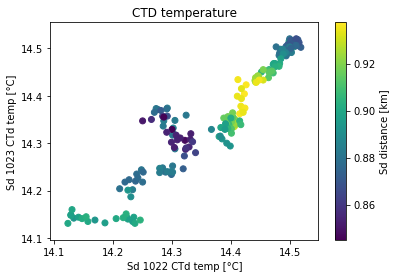

In [80]:
plt.scatter(DS22.TEMP_CTD_RBR_MEAN[:200], DS23.TEMP_CTD_RBR_MEAN[:200], c = dist_SD2223[:200])
plt.colorbar(label= 'Sd distance [km]')
plt.title('CTD temperature')
plt.xlabel('Sd 1022 CTd temp [°C]')
plt.ylabel('Sd 1023 CTd temp [°C]')
#plt.savefig("SD1022_23_corr_CTD_temp.pdf", bbox_inches='tight', transparent=True)

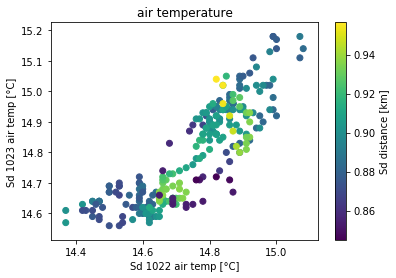

In [73]:
plt.scatter(DS22.TEMP_AIR_MEAN[:250], DS23.TEMP_AIR_MEAN[:250], c = dist_SD2223[:250])
plt.colorbar(label= 'Sd distance [km]')
plt.title('air temperature')
plt.xlabel('Sd 1022 air temp [°C]')
plt.ylabel('Sd 1023 air temp [°C]')
#plt.savefig("SD1022_23_corr_air_temp.pdf", bbox_inches='tight', transparent=True)

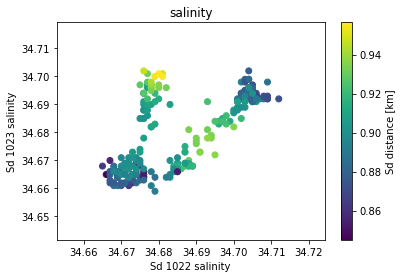

In [74]:
plt.scatter(DS22.SAL_RBR_MEAN[:250], DS23.SAL_RBR_MEAN[:250], c = dist_SD2223[:250])
plt.colorbar(label= 'Sd distance [km]')
plt.title('salinity')
plt.xlabel('Sd 1022 salinity')
plt.ylabel('Sd 1023 salinity')
#plt.savefig("SD1022_23_corr_salinity.pdf", bbox_inches='tight', transparent=True)

Text(0, 0.5, 'Sd 1023 wind speed [m/s]')

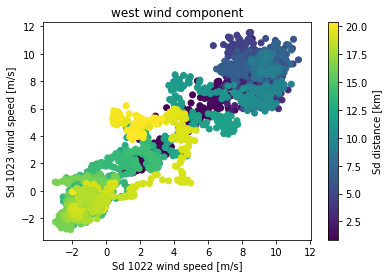

In [81]:
plt.scatter(DS22.UWND_MEAN[:2500], DS23.UWND_MEAN[:2500], c = dist_SD2223[:2500])
plt.colorbar(label= 'Sd distance [km]')
plt.title('west wind component')
plt.xlabel('Sd 1022 wind speed [m/s]')
plt.ylabel('Sd 1023 wind speed [m/s]')
#plt.savefig("SD1022_23_uwind.pdf", bbox_inches='tight', transparent=True)

In [2]:
# interpolatiom from online example: interpolates where nans are: 
import numpy as np

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

#temp_ctd_int= np.array(DS.TEMP_CTD_MEAN)
#nans, x= nan_helper(temp_ctd_int)
#temp_ctd_int[nans]= np.interp(x(nans), x(~nans), temp_ctd_int[~nans])

#print (y.round(2))
#print(x)
#[ 1.    1.    1.    1.33  1.67  2.    2.    1.    0.  ]
#len(y)
#len(DS.time)
#plt.plot(wind_10m)
#plt.plot(DS.TEMP_CTD_MEAN)


In [3]:
#1 interpolate all the variables

# v wind 
vwind_int= np.array(DS.VWND_MEAN)
nans, x= nan_helper(vwind_int)
vwind_int[nans]= np.interp(x(nans), x(~nans), vwind_int[~nans])
# u wind
uwind_int= np.array(DS.UWND_MEAN)
nans, x= nan_helper(uwind_int)
uwind_int[nans]= np.interp(x(nans), x(~nans), uwind_int[~nans])
# temp air 
temp_air_int= np.array(DS.TEMP_AIR_MEAN)
nans, x= nan_helper(temp_air_int)
temp_air_int[nans]= np.interp(x(nans), x(~nans), temp_air_int[~nans])
# temp ctd
temp_ctd_int= np.array(DS.TEMP_CTD_MEAN)
nans, x= nan_helper(temp_ctd_int)
temp_ctd_int[nans]= np.interp(x(nans), x(~nans), temp_ctd_int[~nans])
# temp IR 
temp_ir_int= np.array(DS.TEMP_IR_UNCOR_MEAN)
nans, x= nan_helper(temp_ir_int)
temp_ir_int[nans]= np.interp(x(nans), x(~nans), temp_ir_int[~nans])
# humidity 
rh_int= np.array(DS.RH_MEAN)
nans, x= nan_helper(rh_int)
rh_int[nans]= np.interp(x(nans), x(~nans), rh_int[~nans])
# sal
sal_int= np.array(DS.SAL_MEAN)
nans, x= nan_helper(sal_int)
sal_int[nans]= np.interp(x(nans), x(~nans), sal_int[~nans])
# pressure 
pres_int= np.array(DS.BARO_PRES_MEAN)
nans, x= nan_helper(pres_int)
pres_int[nans]= np.interp(x(nans), x(~nans), pres_int[~nans])

# par
par_int= np.array(DS.PAR_AIR_MEAN)
nans, x= nan_helper(par_int)
par_int[nans]= np.interp(x(nans), x(~nans), par_int[~nans])

# lat
lat_int= np.array(DS.latitude)
nans, x= nan_helper(lat_int)
lat_int[nans]= np.interp(x(nans), x(~nans), lat_int[~nans])

# lon
lon_int= np.array(DS.longitude)
nans, x= nan_helper(lon_int)
lon_int[nans]= np.interp(x(nans), x(~nans), lon_int[~nans])


#2 cut the variables  (at wind sensor failure time)

vwind_int= vwind_int[:95582]
uwind_int= uwind_int[:95582]
temp_air_int= temp_air_int[:95582]
temp_ctd_int= temp_ctd_int[:95582]
rh_int= rh_int[:95582]
temp_ir_int= temp_ir_int[:95582]
pres_int= pres_int[:95582]
sal_int= sal_int[:95582]
par_int= par_int[:95582]
lat_cut= lat_int[:95582]
lon_cut=lon_int[:95582]
time_cut= DS.time[:95582]
#3 recalculate wind to 10m, heatfluxes, R, density gradient
#NAME VARIABLES/CHANGE UNITS: 
u=uwind_int
v=vwind_int
wind_1min=SD.wind(u,v)
Par_Wm2_1min=par_int*0.327 #change units from micromol per s m  to W/m^2 https://www.apogeeinstruments.com/conversion-ppfd-to-watts/

#Correcting wind to 10m reference height from Schmidt et. al. 2017
Z= 10 # refrence height in m 
zo= 1.52e-4 # roughness length [m]
zm= 5.2 # measuremnt height [m] of sensor on Saildrone
wind_10m=wind_1min*(np.log(Z/zo)/np.log(zm/zo))
#diff_wind=(wind_10m-wind)

# calculate heat fluxes and spec. humidty 
import SD_Project as SD
heat_sensible= -SD.Q_sensible(wind_10m, temp_air_int, temp_ctd_int)
hum_spec_1min= SD.humidity_specific3(rh_int, temp_air_int, pres_int)
hum_spec_sat_1min= SD.humidity_spec_sat3(rh_int, temp_air_int, pres_int)
heat_latent= -SD.Q_latent(wind_10m, hum_spec_sat_1min, hum_spec_1min)

dist_covered_1min= sw.dist(lat_cut,lon_cut, units='km')[0]
# distance coverd in km is first array, 2nd array bearing,
#bearing= sw.dist(DS.latitude,DS.longitude)[1] 
p = np.zeros(len(temp_ctd_int))
p[:]=0.5 # pressure in dbar, instrument installed at -0.5m
SA= gsw.SA_from_SP(sal_int,p, lon_cut, lat_cut)
CT = gsw.CT_from_t(SA,temp_ctd_int,p)

density=gsw.rho(SA,CT,p)
alpha= gsw.alpha(SA,CT,p)
beta = gsw.beta(SA,CT,p)

delta_dens=np.abs(np.diff(density))
density_grad_1min=(delta_dens)/(dist_covered_1min) # [kg/m^3*1/km]
dg=( delta_dens/dist_covered_1min)
#claculate density gradient



l=len(dist_covered_1min)
distance_from_NZ= np.zeros(l)

for i in range(0,l):
    if i==0:
        distance_from_NZ[i]=dist_covered_1min[0]
    else:
        distance_from_NZ[i]=distance_from_NZ[i-1]+dist_covered_1min[i]

In [166]:

x=detrend_y#[:1440]#[::60]#temp_air_int
#temp_air_int#heat_latent#heat_sensible#wind_10m

#np.array([1,2,3,2,1,4,2,2,4,5,2])

N= 1440#len(x)
x_bar= np.nanmean(x)
#n=np.arange(1,N-1)
C= np.zeros(N)
for n in range (1,N): 
    C[n]= np.sum((x[:-n]-x_bar)*(x[n:]-x_bar))/np.sum((x-x_bar)**2)

#t=np.zeros(2*len(x)) 
#for n in range(-N,N):
   #t[n]=np.sum(C[n])

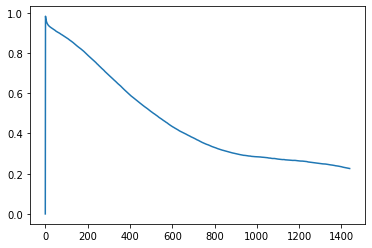

In [167]:
plt.plot(C)

-4.0255906712527434e-05 12.129857559964112


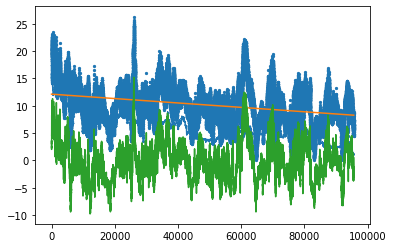

Signature:
curve_fit(
    f,
    xdata,
    ydata,
    p0=None,
    sigma=None,
    absolute_sigma=False,
    check_finite=True,
    bounds=(-inf, inf),
    method=None,
    jac=None,
    **kwargs,
)
Docstring:
Use non-linear least squares to fit a function, f, to data.

Assumes ``ydata = f(xdata, *params) + eps``

Parameters
----------
f : callable
    The model function, f(x, ...).  It must take the independent
    variable as the first argument and the parameters to fit as
    separate remaining arguments.
xdata : An M-length sequence or an (k,M)-shaped array for functions with k predictors
    The independent variable where the data is measured.
ydata : M-length sequence
    The dependent data --- nominally f(xdata, ...)
p0 : None, scalar, or N-length sequence, optional
    Initial guess for the parameters.  If None, then the initial
    values will all be 1 (if the number of parameters for the function
    can be determined using introspection, otherwise a ValueError
    is raised

In [163]:
plt.plot(temp_ctd_int)
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy
import matplotlib.patches as mpl_patches

x1= np.arange(0,len(temp_ctd_int))
y1= wind_10m
#x= x1[~np.isnan(y1)] #removing nan 
#y= y1[~np.isnan(y1)]

fig = plt.scatter(x1,y1, s=5)
curve_fit?
#define function
#creating OLS regression
#slope, intercept, r_value, p_value, std_err = stats.linregress(x1,y1)
def f(x,a,c):
    return a*(x)+c

fit=curve_fit(f,x1,y1)
print(*fit [0])
plt.plot(x1,f(x1,*fit[0]))
detrend_y=y1- f(x1,*fit[0])
plt.plot(detrend_y)

Text(0.5, 1.0, 'Autocorrelation for water temp SD 1020 \n decorrelation timescale ~ 25 days ')

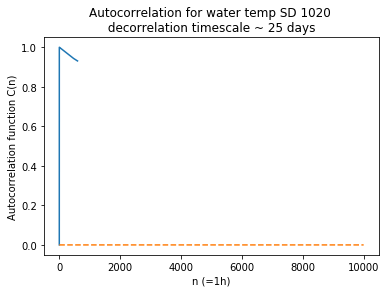

In [136]:
b= np.arange(0,10000)
c= np.zeros(10000)

plt.plot(C)
plt.plot(b,c, '--')
plt.ylabel('Autocorrelation function C(n)')
plt.xlabel('n (=1h)')

plt.title('Autocorrelation for water temp SD 1020 \n decorrelation timescale ~ 25 days ')
#plt.xlim(0,1000)
#plt.savefig('SD1020_autocorrelation_CTD_temp.pdf')

In [134]:
np.where(C<0)

(array([], dtype=int64),)

In [88]:
#((550*60)/60)/24 #[ 11 Tage]
#550/24
((5*60)/60)/24

0.20833333333333334

Text(0.5, 1.0, ' Autocorrelation for lat. heat flux SD 1020')

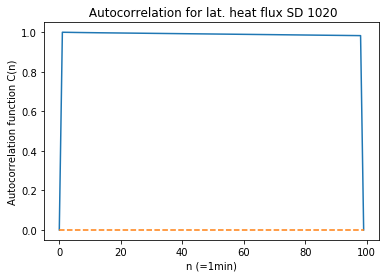

In [88]:
b= np.arange(0,100)
c= np.zeros(100)

plt.plot(C)
plt.plot(b,c, '--')
plt.ylabel('Autocorrelation function C(n)')
plt.xlabel('n (=1min)')
plt.title(' Autocorrelation for lat. heat flux SD 1020')
#plt.savefig("SD1020_autocorrelation_lat_heatflux.pdf", bbox_inches='tight',transparent=True)
#C[2340:2440]

In [83]:
10000/60/24

6.944444444444444

In [23]:
DS20.TEMP_AIR_MEAN[1:60]

<xarray.DataArray 'TEMP_AIR_MEAN' (obs: 59)>
array([  nan,   nan,   nan,   nan, 15.95,   nan,   nan,   nan,   nan, 16.36,
         nan,   nan,   nan,   nan, 16.36,   nan,   nan,   nan,   nan, 16.74,
         nan,   nan,   nan,   nan, 17.3 ,   nan,   nan,   nan,   nan, 17.36,
         nan,   nan,   nan,   nan, 17.26,   nan,   nan,   nan,   nan, 17.31,
         nan,   nan,   nan,   nan, 17.2 ,   nan,   nan,   nan,   nan, 17.18,
         nan,   nan,   nan,   nan, 17.04,   nan,   nan,   nan,   nan])
Coordinates:
    trajectory  float32 1020.0
    time        (obs) datetime64[ns] ...
    latitude    (obs) float64 ...
    longitude   (obs) float64 ...
Dimensions without coordinates: obs
Attributes:
    standard_name:              air_temperature
    long_name:                  Air temperature
    units:                      degrees_c
    last_calibrated:            2016-07-12
    update_period:              1000
    model_product_page:         
    device_name:                Rotronic AT/RH (20147766)
    installed_date:             2018-06-07T22:36:51.450713Z
    nominal_sampling_schedule:  60s on, 240s off, centered at :00
    installed_height:           2.3
    serial_number:              20147766
    vendor_name:                Rotronic
    model_name:                 HC2-S3